# Differentiable Physics II:  Automatic Differentiation of Verlet Integration


Before we have used a simple force field which was defined as:

$$ F(x) = -kx $$

Moving forward we use a set of $K$ attractors each with a position $k_i$. The force function is then defined as:

$$ F(x) = \sum_{i=1}^N \frac{k_i - x}{||k_i - x||^2} $$

Finding the derivate of the force field is a bit more involved but it is still possible to do it analytically. However we can use an autograd library such as jax, to get the gradient of the loss of the solver. 

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Randomly sampled attractors')

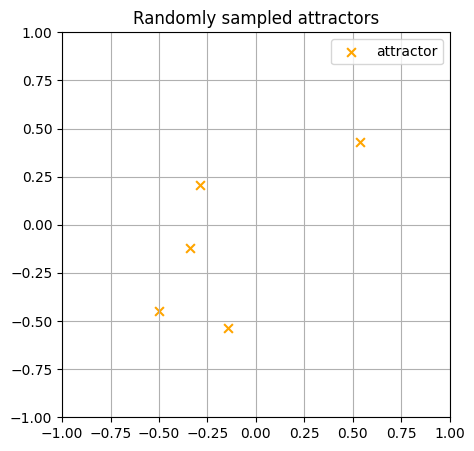

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import value_and_grad, jit, random
from jax.typing import ArrayLike

key = random.PRNGKey(0)

n_attractors = 5
attractors = random.uniform(key, (n_attractors, 2), minval=-1, maxval=1, dtype=jnp.float32)

plt.figure(figsize=(5,5))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='x', s=40, label='attractor')
plt.legend()
plt.title('Randomly sampled attractors')


In [2]:
from functools import partial

@jit
def force(x : jnp.ndarray, attractors : jnp.ndarray) -> jnp.ndarray:
    f = jnp.zeros_like(x)

    for a in attractors:
        d = a - x
        f += d / jnp.linalg.norm(d)**2

    return f

@partial(jit, static_argnames=('dt', 'm'))
def verlet_step(
    x : jnp.ndarray,
    v : jnp.ndarray,
    dt : float,
    m : float, 
    attractors : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:

    x_fwd = jnp.asarray(x) + (v * dt) + (0.5 * force(x, attractors) * dt * dt / m)
    v_fwd = jnp.asarray(v) + (0.5 * (force(x, attractors) + force(x_fwd, attractors)) * dt / m)

    return x_fwd, v_fwd



A simple forward simulation of the system with 300 iterations:

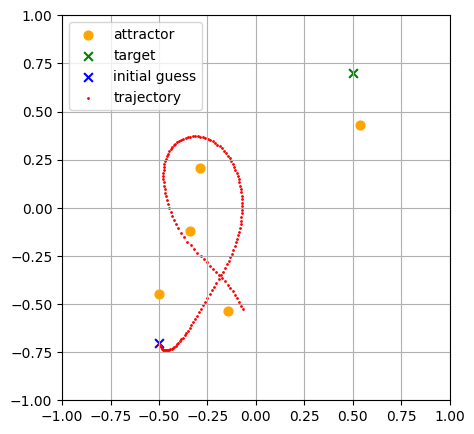

In [3]:
x0_guess = jnp.array([-0.5, -0.7], dtype=jnp.float32)
v0_guess = jnp.array([0.2, -0.8], dtype=jnp.float32)

xn_star = jnp.array([0.5, 0.7], dtype=jnp.float32)

n_iterations = 150
dt = 0.01
m = 1.0

x = x0_guess.copy()
v = v0_guess.copy()

xs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)
vs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)

for i in range(n_iterations):
    x, v = verlet_step(x, v, dt, m, attractors)
    xs = xs.at[i, :].set(x.copy())
    vs = vs.at[i, :].set(v.copy())

plt.figure(figsize=(5,5))

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.grid()

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='o', s=40, label='attractor')  
plt.scatter(xn_star[0], xn_star[1], c='green', marker='x', s=40, label='target')
plt.scatter(x0_guess[0], x0_guess[1], c='blue', marker='x', s=40, label='initial guess')
plt.scatter(xs[:,0], xs[:,1], c='red', marker='o', s=1, label='trajectory')

plt.legend()



To find the appropriate initial conditions we use the gradient descent method again. This time we perform all the differentiation using jit. 

In [4]:
@jit
def loss(x :  ArrayLike, target : ArrayLike) -> float:
    return jnp.mean((target - x) ** 2)

What is special about the force function, is how the velocity can increase exponentially when the distance between the attractor and the particle is small. This is a problem for the gradient descent as we have very high peaks.

Text(0.5, 1.0, 'Simulation loss (log scale)')

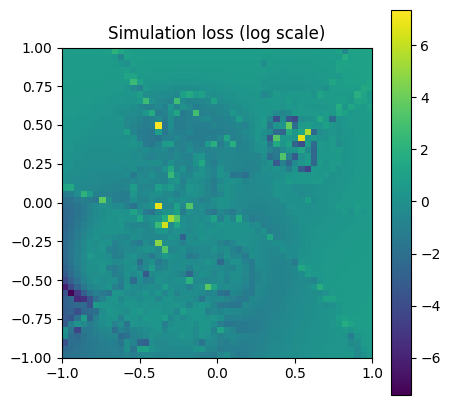

In [5]:
grid_size = 50
x = jnp.linspace(-1, 1, grid_size)
y = jnp.linspace(-1, 1, grid_size)

X, Y = jnp.meshgrid(x, y)
x0s = jnp.stack([X, Y], axis=-1).reshape(-1, 2)

loss_grid = jnp.zeros((grid_size, grid_size), dtype=jnp.float32)

for i, x0 in enumerate(x0s):
    x = x0.copy()
    v = jnp.array([0.0, 0.0], dtype=jnp.float32)
    for j in range(n_iterations):
        x, v = verlet_step(x, v, dt, m, attractors)
    
    loss_grid = loss_grid.at[i // grid_size, i % grid_size].set(loss(x, xn_star))

plt.figure(figsize=(5,5))

loss_grid = jnp.log(loss_grid)
plt.imshow(loss_grid, extent=[-1,1,-1,1], origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Simulation loss (log scale)')

The actual simulation method:

In [28]:
def verlet_simulation(
        x0 : jnp.ndarray, 
        v0 : jnp.ndarray, 
        xn_star : jnp.ndarray,
        dt : float, 
        n : int, 
        m : float, 
        attractors : jnp.ndarray) -> float:
    x = x0.copy()
    v = v0.copy()
    
    for i in range(n):
        x, v = verlet_step(x, v, dt, m, attractors)

    return loss(x, xn_star) + 0.1 * jnp.mean(v ** 2) - 0.08 * jnp.mean(x ** 2)

Finally we use the ``value_and_grad`` method from jax to get the gradient and the actual loss value.

In [29]:
loss_grad = value_and_grad(verlet_simulation, argnums=(0, 1))

In [41]:
optimization_steps = 30

learning_rate = 0.2

x0 = x0_guess.copy()
v0 = v0_guess.copy()

losses = jnp.zeros(optimization_steps, dtype=jnp.float32)
x0s = jnp.zeros((optimization_steps, 2), dtype=jnp.float32)
v0s = jnp.zeros((optimization_steps, 2), dtype=jnp.float32)

grad_x_momentum = jnp.zeros_like(x0)
grad_v_momentum = jnp.zeros_like(v0)

beta = 0.3

for i in range(optimization_steps):

    loss_x, (grad_x, grad_v) = loss_grad(x0, v0, xn_star, dt, n_iterations, m, attractors)

    # normalize gradients
    grad_x /= jnp.linalg.norm(grad_x) 
    grad_v /= jnp.linalg.norm(grad_v)

    grad_x_momentum = beta * grad_x_momentum + (1-beta) * -grad_x * learning_rate
    grad_v_momentum = beta * -grad_v * learning_rate + (1-beta) * grad_v_momentum

    x0 += grad_x_momentum * learning_rate
    v0 += grad_v_momentum * learning_rate

    losses = losses.at[i].set(loss_x)

    x0s = x0s.at[i, :].set(x0.copy())
    v0s = v0s.at[i, :].set(v0.copy())

    print(F"loss {loss_x}")

loss 1.1141951084136963
loss 1.00774347782135
loss 1.1625126600265503
loss 1.2593746185302734
loss 1.334236741065979
loss 1.1738927364349365
loss 1.023000955581665
loss 1.1862623691558838
loss 1.5476042032241821
loss 1.2757861614227295
loss 1.0369740724563599
loss 0.8410178422927856
loss 1.369821310043335
loss 1.2388789653778076
loss 1.8256721496582031
loss 2.327493906021118
loss 0.7795138955116272
loss 1.0692256689071655
loss 0.4957062900066376
loss 0.46678221225738525
loss 0.5874731540679932
loss 0.7391888499259949
loss 0.4196147918701172
loss 0.5170918703079224
loss 0.783020555973053
loss 0.4422379434108734
loss 0.7549909353256226
loss 0.9447535276412964
loss 0.658780574798584
loss 0.016736075282096863


Text(0, 0.5, 'loss')

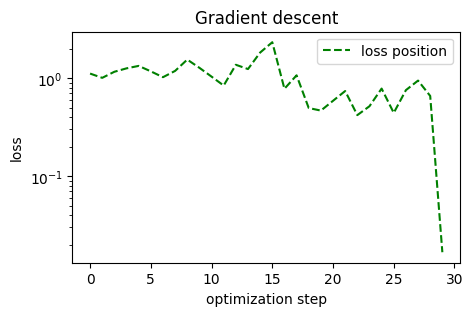

In [42]:
plt.figure(figsize=(5,3))

plt.plot(losses, label="loss position", color="green", linestyle="dashed")
# y axis log
plt.yscale("log")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")

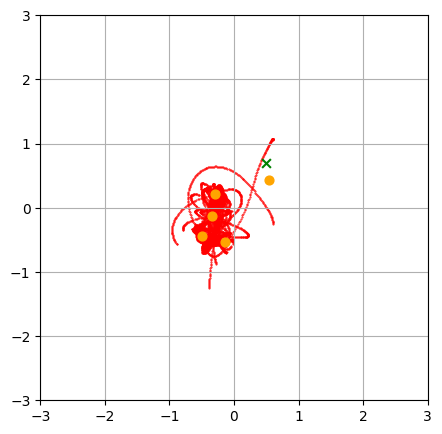

In [44]:
plt.figure(figsize=(5,5))

plt.xlim(-3,3)
plt.ylim(-3,3)

plt.grid()

for j in range(0, optimization_steps, 1):
    x = x0s[j, :].copy()
    v = v0s[j, :].copy()

    xs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)
    vs = jnp.zeros((n_iterations, 2), dtype=jnp.float32)

    for i in range(n_iterations):
        x, v = verlet_step(x, v, dt, m, attractors)
        xs = xs.at[i, :].set(x.copy())
        vs = vs.at[i, :].set(v.copy())

    plt.scatter(xs[:,0], xs[:,1], c='red', marker='o', s=0.2, label='trajectory')

plt.scatter(attractors[:,0], attractors[:,1], c='orange', marker='o', s=40, label='attractor')  
plt.scatter(xn_star[0], xn_star[1], c='green', marker='x', s=40, label='target')